# Image Colorization Prototype
This prototype utilizes the GAN architecture to attempt colorizing grayscale images. The images are scraped from YouTube videos and converted into `LAB` color space where only the lightness layer will be used as input to the generator.

Information on the original architecture can be found below:

- Paper: https://arxiv.org/pdf/1702.06674.pdf

- Code: https://github.com/ccyyatnet/COLORGAN

In [1]:
import numpy as np
import tables
import cv2
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Dense, BatchNormalization, ReLU, LeakyReLU, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE, BinaryCrossentropy

In [2]:
# Model hyperparams and constants
GEN_LR = 1e-4
DISC_LR = 3e-4
EPOCHS = 100
BATCH_SIZE = 20
IMG_HEIGHT = 128
IMG_WIDTH = 128
Z_DIM = 100

## Data Loading and Preparation

The orignal screenshots are of $360 \times 480$ pixels. However, to limit memeory usage and computation time, they will be cropped to $128 \times 128$ from the center. The function below trims images to the desired dimension. 

In [3]:
def trim_images(image, height, width):
    image_height = image.shape[1]
    image_width = image.shape[2]
    
    out = image.copy()
    if image_height > height:
        top = (image_height-height)//2
        bottom = image_height-height-top
        out = out[:,top:-bottom, :, :]
    if image_width > width:
        left = (image_width-width)//2
        right = image_width-width-left
        out = out[:, :, left:-right, :]
    return out

The whole H5 database consists of 17,000 images. We will define a function below to load images by index since the whole dataset will not fit into memory. It also transforms the images into `LAB` color space, scales the values to be $\in [-1,1]$, and trims the images if needed.

In [4]:
def load_training_data(start_idx=None, end_idx=None):
    mdb = tables.open_file('youtube_data.h5')
    tbl = mdb.root.Train
    if (start_idx is None) and (end_idx is None):
        L = tbl.cols.L[:]
        A = tbl.cols.A[:]
        B = tbl.cols.B[:]
    else:
        assert (start_idx is not None) and (end_idx is not None), 'Please provide both start and end indices.'
        start_idx = int(start_idx*360*480)
        end_idx = int(end_idx*360*480)
        L = tbl.cols.L[start_idx:end_idx]
        A = tbl.cols.A[start_idx:end_idx]
        B = tbl.cols.B[start_idx:end_idx]
    mdb.close()
    
    img_size = (360, 480)
    n = int(L.shape[0]/np.prod(img_size))
    L = L.reshape(n, img_size[0], img_size[1])
    A = A.reshape(n, img_size[0], img_size[1])
    B = B.reshape(n, img_size[0], img_size[1])
    
    data = np.stack((L, A, B), axis=3)/127.5-1
    data = trim_images(data, IMG_HEIGHT, IMG_WIDTH)
    return data

## Model

### Generator
The generator is a deep CNN that takes the lightness layer of images and a noise vector as inputs and outputs the `ab` channels. The output of each convolutional layer has the same height and width as the original input which allows for continuous concatenation of the lightness layer. There is no pooling layer and hence no downsampling is performed. 

In [5]:
def make_generator_model():
    L = Input((IMG_HEIGHT,IMG_WIDTH,1), name='L')
    z = Input((Z_DIM), name='z')

    h0 = Dense(IMG_HEIGHT*IMG_WIDTH)(z)
    h0 = tf.reshape(h0, [-1, IMG_HEIGHT, IMG_WIDTH, 1])
    h0 = BatchNormalization()(h0)
    h0 = ReLU()(h0)

    h1 = Concatenate(axis=3)([L, h0])
    h1 = Conv2D(128, (7,7), padding='same')(h1)
    h1 = BatchNormalization()(h1)
    h1 = ReLU()(h1)

    h2 = Concatenate(axis=3)([L, h1])
    h2 = Conv2D(64, (5,5), padding='same')(h2)
    h2 = BatchNormalization()(h2)
    h2 = ReLU()(h2)

    h3 = Concatenate(axis=3)([L, h2])
    h3 = Conv2D(64, (5,5), padding='same')(h3)
    h3 = BatchNormalization()(h3)
    h3 = ReLU()(h3)

    h4 = Concatenate(axis=3)([L, h3])
    h4 = Conv2D(64, (5,5), padding='same')(h4)
    h4 = BatchNormalization()(h4)
    h4 = ReLU()(h4)

    h5 = Concatenate(axis=3)([L, h4])
    h5 = Conv2D(32, (5,5), padding='same')(h5)
    h5 = BatchNormalization()(h5)
    h5 = ReLU()(h5)

    h6 = Concatenate(axis=3)([L, h5])
    h6 = Conv2D(2, (5,5), padding='same', activation='tanh')(h6)

    return tf.keras.Model(inputs=[L, z], outputs=h6)

### Discriminator
The discriminator is also a deep CNN where output of each layer has the same height and width as the input layer with two dense layers on top. The dense layers use linear activation so the final output of discriminator can be interpreted as logits. It also acts more as a critic rather than a discriminator since it does not predict the probability of whether generator output belongs to real or fake output but simply scores the output. 

In [6]:
def make_discriminator_model():
    image = Input((IMG_HEIGHT,IMG_WIDTH,2), name='image')
    h0 = Conv2D(16, (5,5), padding='same')(image)
    h0 = LeakyReLU(0.2)(h0)

    h1 = Conv2D(32, (5,5), padding='same')(h0)
    h1 = BatchNormalization()(h1)
    h1 = LeakyReLU(0.2)(h1)

    h2 = Conv2D(64, (5,5), padding='same')(h1)
    h2 = BatchNormalization()(h2)
    h2 = LeakyReLU(0.2)(h2)

    h3 = Conv2D(128, (5,5), padding='same')(h2)
    h3 = BatchNormalization()(h3)
    h3 = LeakyReLU(0.2)(h3)

    h4 = Flatten()(h3)
    h4 = Dense(16)(h4)

    h5 = Dense(1)(h4)
    return tf.keras.Model(inputs=image, outputs=h5)

### Loss Functions

The loss for the generator is defined as the mean squared error per pixel between the real and fake image. The loss for the discriminator is sum of cross entropy of the real and fake.

In [7]:
cross_entropy = BinaryCrossentropy(from_logits=True)
    
def generator_loss(ab_real, ab_fake):
    shape = np.prod(ab_real.shape)
    return MSE(tf.reshape(ab_real, shape=(shape,)), tf.reshape(ab_fake, shape=(shape,)))

def discriminator_loss(logits_real, logits_fake):
    real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
    fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
    total_loss = real_loss + fake_loss
    return total_loss

### Optimizers
We will use Adam here with higher learning rate for the discriminator than the generator for training stability. Clipping is applied on the discriminator's gradients to avoid exploding gradients.

In [8]:
# Optimizers
generator_optimizer = Adam(learning_rate=GEN_LR)
discriminator_optimizer = Adam(learning_rate=DISC_LR, clipvalue=0.1)

## Training

We will just use the first 200 images as the training set and run 100 epochs for sake of efficiency. We will grab images from the H5 file on the fly using the function defined above. A custom training function is defined to tape and apply gradients for the generator and discriminator separately. 

In [9]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [10]:
@tf.function
def train_step(train_data):
    L = train_data[:,:,:,:1]
    ab = train_data[:,:,:,1:]
    z = tf.random.uniform((L.shape[0], Z_DIM),-1,1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_ab = generator([L,z], training=False)

        logits_real = discriminator(ab, training=False)
        logits_fake = discriminator(generated_ab, training=False)

        gen_loss = generator_loss(ab, generated_ab)
        disc_loss = discriminator_loss(logits_real, logits_fake)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [11]:
def train():
    for epoch in range(EPOCHS):
        indices = np.arange(0,200,BATCH_SIZE)
        for idx in indices:
            start_idx = idx
            end_idx = start_idx+BATCH_SIZE
            train_data = load_training_data(start_idx, end_idx) 
            gen_loss, disc_loss = train_step(train_data)

        if (epoch + 1) % 10 == 0:
            # Save weights
            w = dict()
            w['generator'] = generator.get_weights()
            w['discriminator'] = discriminator.get_weights()
            with open('model_weights.pickle', 'wb') as file:
                pickle.dump(w, file)
     
            print('Epcoh: %d, generator loss: %.4f, discriminator loss: %.4f'%(epoch+1, gen_loss, disc_loss))

In [12]:
train()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epcoh: 10, generator loss: 0.0032, discriminator loss: 0.0041
Epcoh: 20, generator loss: 0.0024, discriminator loss: 0.0073
Epcoh: 30, generator loss: 0.0028, discriminator loss: 1.9308
Epcoh: 40, generator loss: 0.0029, discriminator loss: 0.3033
Epcoh: 50, generator loss: 0.0029, discriminator loss: 0.0015
Epcoh: 60, generator loss: 0.0027, discriminator loss: 0.0020
Epcoh: 70, generator loss: 0.0027, discriminator loss: 0.0003
Epcoh: 80, generator loss: 0.0028, discriminator loss: 0.2537
Epcoh: 90, g

## Evalution

### Performance on Training Images

In [38]:
idx = np.random.randint(0, 200, 3)

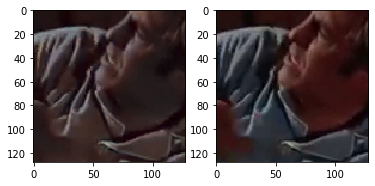

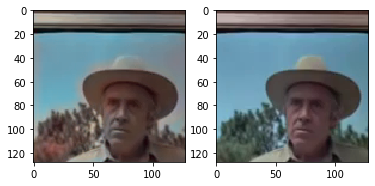

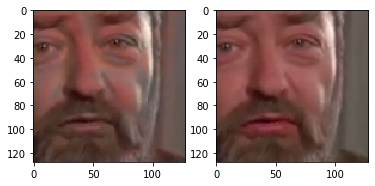

In [39]:
for i in idx:
    train_data = load_training_data(i, i+1)
    L = train_data[:,:,:,:1]
    ab = train_data[:,:,:,1:]
    z = tf.random.uniform((L.shape[0], Z_DIM),-1,1)
    generated_ab = generator([L,z], training=False)
    lab_data = np.concatenate(((L[0]+1)*127.5, (generated_ab[0]+1)*127.5), axis=2).astype('uint8')
    img_fake = cv2.cvtColor(lab_data, cv2.COLOR_LAB2RGB)
    lab_data = np.concatenate(((L[0]+1)*127.5, (ab[0]+1)*127.5), axis=2).astype('uint8')
    img_real = cv2.cvtColor(lab_data, cv2.COLOR_LAB2RGB)   
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img_fake)
    ax[1].imshow(img_real)
    plt.show()

The left column shows the generator output and right column shows images with original colors. We see that the generator seems to be able to identify different regions (objects) of the images but it sometimes fails to predict sensible colors.

### Performance on Test Images

In [40]:
idx = np.random.randint(200, 400, 3)

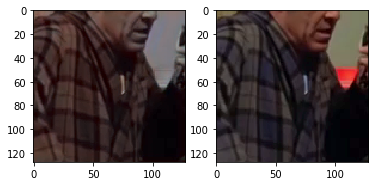

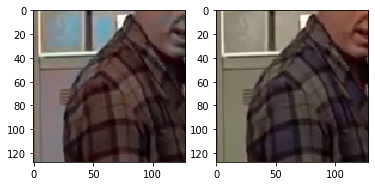

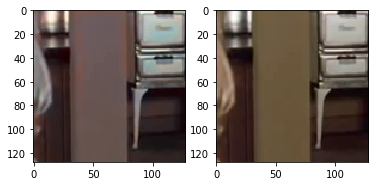

In [41]:
for i in idx:
    train_data = load_training_data(i, i+1)
    L = train_data[:,:,:,:1]
    ab = train_data[:,:,:,1:]
    z = tf.random.uniform((L.shape[0], Z_DIM),-1,1)
    generated_ab = generator([L,z], training=False)
    lab_data = np.concatenate(((L[0]+1)*127.5, (generated_ab[0]+1)*127.5), axis=2).astype('uint8')
    img_fake = cv2.cvtColor(lab_data, cv2.COLOR_LAB2RGB)
    lab_data = np.concatenate(((L[0]+1)*127.5, (ab[0]+1)*127.5), axis=2).astype('uint8')
    img_real = cv2.cvtColor(lab_data, cv2.COLOR_LAB2RGB)   
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img_fake)
    ax[1].imshow(img_real)
    plt.show()

The generator defaults to the brownish colors on images it has never seen before since it's a safer choice than colors on the extremes of the specturm (smaller loss). The performance could be improved with more training data and perhaps longer training time and regularizations can be applied if the perfomance on the trainning set is still much better than on the test set.